In [1]:
# Load Libraries
import re
import numpy as np
import pandas as pd
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
## join data
test['Is_Response'] = np.nan
alldata = pd.concat([train, test]).reset_index(drop=True)

In [4]:
alldata.head(10)

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy
5,id10331,We had - rooms. One was very nice and clearly ...,InternetExplorer,Desktop,happy
6,id10332,My husband and I have stayed in this hotel a f...,Firefox,Tablet,not happy
7,id10333,My wife & I stayed in this glorious city a whi...,Google Chrome,Mobile,happy
8,id10334,My boyfriend and I stayed at the Fairmont on a...,Internet Explorer,Desktop,happy
9,id10335,"Wonderful staff, great location, but it was de...",Chrome,Tablet,not happy


In [5]:
alldata.tail(10)

,User_ID,Description,Browser_Used,Device_Used,Is_Response
68326,id109526,This hotel may not be the most glamorous in SF...,Firefox,Desktop,NaN
68327,id109527,Stayed here for - nights & had a room overlook...,Edge,Mobile,NaN
68328,id109528,We stayed for three nights (June ----). The lo...,Firefox,Desktop,NaN
68329,id109529,We spent - nights in a king castia. The beds a...,Firefox,Tablet,NaN
68330,id109530,We booked our flight-hotel package on Expedia ...,Mozilla,Mobile,NaN
68331,id109531,I stayed at the hotel and towers for a confere...,Chrome,Mobile,NaN
68332,id109532,Trying to stay within the Marriott family and ...,Internet Explorer,Tablet,NaN
68333,id109533,"We stayed for - nights with our little dog,ver...",Edge,Desktop,NaN
68334,id109534,Stayed at the Yotel over the weekend and was v...,InternetExplorer,Desktop,NaN
68335,id109535,The Blakely is is comfortable is every way: th...,Mozilla Firefox,Mobile,NaN


### New approach for feature engineering
Clean data in following way
- Tokeninze sentences
- no. of questions
- no. of exclamation marks
- no. of positives words
- no. of negative words
- no. of uppercase words
- no. of negation phrases
- Remove non-english tokens
- Tag each token using POS tagger
- Remove noun or pronoun words

### EDA
- Happy/Unhappy classes distribution
- Based on no. of +ve/-ve words
- Based on difference between +ve/-ve words count
- Based on no. of uppercases
- Based on exclamation
- Based on questions

### Solution model
- Create features using TF-IDF vectorizer
- Access the accuracy and threshold using ROC curve
- Use rule based prediction along with ML if no. of false positive/negative is high

In [6]:
# Read positive words from file
with open(r'/home/romee/opinion_words/pos_words.txt', 'r') as f:
    pos_words = f.read().splitlines()

# Read negative words from file
with open(r'/home/romee/opinion_words/neg_words.txt', 'r') as f:
    neg_words = f.read().splitlines()

In [7]:
# Convert to set for faster search
pos_words = set(pos_words)
neg_words = set(neg_words)

In [8]:
# Function to decode any string type to unicode
def to_unicode(obj, encoding='utf-8'):
    if isinstance(obj, basestring):
        if not isinstance(obj, unicode):
            try:
                obj = obj.decode(encoding, errors='ignore')
            except UnicodeDecodeError:
                obj = obj.decode('windows-1252')
    return obj

In [9]:
# Function to remove special words
def remove_special_chars(text):
    unwanted = [",", ":", "\"", "=", "&", ";", "%", "$", "@", "%", "^", "*", "(", ")", "{", "}", "[", "]", "|", "/", "\\", ">", "<", "-", "!", "?", ".", "'", "--", "---", "#", "''", '``', '"']
    txt = [w for w in text.split() if w not in unwanted]
    return " ".join(txt)

In [10]:
# Function to count questions
def count_ques(text):
    return text.count('?')

In [11]:
# Function to calculate no. of exclamation marks in a text
def count_exclamation(text):
    return text.count("!")

In [12]:
# Function to calculate no. of quotes in a text
def count_quotes(text):
    return text.count("'") + text.count('"')

In [13]:
# Function to count uppercase words
def count_uppercase(text):
    return len([w for w in text.split() if w == w.upper()])

In [14]:
# Function to remove pronouns from tokens
def remove_pron(text):
    tok = to_unicode(text)
    tok = nlp(tok)
    tok = [token for token in tok if token.pos_ != 'PRON']
    tok = [token.text for token in tok if token.pos_ != 'NOUN']
    return " ".join(tok)

In [15]:
# Function to count negative words
def count_nwords(text):
    return len([w for w in text.split() if w in neg_words])

In [16]:
# Function to count positive words
def count_pwords(text):
    return len([w for w in text.split() if w in pos_words])

In [17]:
# Function to clean text data
stops = set(stopwords.words("english"))
def clean_text(text, lowercase=False, remove_stops=False, lemmatize=False):
    txt = str(text)
    txt = re.sub(r'\n',r' ',txt)
    txt = remove_special_chars(txt)
    txt = re.sub(r'[^A-Za-z0-9\s]',r'',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stops])
    
    if lemmatize:
        lemma = WordNetLemmatizer()
        txt = " ".join([lemma.lemmatize(w) for w in txt.split()])

    return txt

In [18]:
# Create number of questions feature
alldata['questions'] = alldata['Description'].map(lambda x: count_ques(x))

In [19]:
# Create number of exclamation feature
alldata['exclamations'] = alldata['Description'].map(lambda x: count_exclamation(x))

In [20]:
# Create number of uppercase words feature
alldata['upperwords'] = alldata['Description'].map(lambda x: count_uppercase(x))

In [21]:
# Create numbers of quotes feature
alldata['quotes'] = alldata['Description'].map(lambda x: count_quotes(x))

In [22]:
alldata['Description'].iloc[9]

'Wonderful staff, great location, but it was definately the price was high for a standard hotel. The free breakfast was great, actually pretty good quailty for a free buffet. This hotel is in the heart of it all, walking distance to everything. - things, please Hyatt...the coffee was bad and the white ginger line of shampoo-conditioner-soap smells horrible!'

In [23]:
s = alldata['Description'].iloc[9]
s.split('.')

['Wonderful staff, great location, but it was definately the price was high for a standard hotel',
 ' The free breakfast was great, actually pretty good quailty for a free buffet',
 ' This hotel is in the heart of it all, walking distance to everything',
 ' - things, please Hyatt',
 '',
 '',
 'the coffee was bad and the white ginger line of shampoo-conditioner-soap smells horrible!']

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
overall = []
for sentence in s.split('.'):
    pol = sid.polarity_scores(sentence)
    if pol['compound'] != 0.0:
        overall.append(pol['compound'])
    print sentence, pol
print 'Average polarity:',sum(overall)/len(overall)

Wonderful staff, great location, but it was definately the price was high for a standard hotel {'neg': 0.0, 'neu': 0.726, 'pos': 0.274, 'compound': 0.5994}
 The free breakfast was great, actually pretty good quailty for a free buffet {'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.9501}
 This hotel is in the heart of it all, walking distance to everything {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
 - things, please Hyatt {'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'compound': 0.3182}
 {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
 {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
the coffee was bad and the white ginger line of shampoo-conditioner-soap smells horrible! {'neg': 0.399, 'neu': 0.601, 'pos': 0.0, 'compound': -0.807}
Average polarity: 0.265175


In [25]:
# Function to return average polarity
def avg_polarity(text):
    sid = SentimentIntensityAnalyzer()
    overall = []
    new_text = []
    for sentence in text.split('.'):
        pol = sid.polarity_scores(sentence)
        if pol['compound'] == 0.0 or len(sentence) < 3:
            continue
        overall.append(pol['compound'])
        new_text.append(text)
    try:
        avg = sum(overall)/len(overall)
    except:
        avg = 0.0
    new_text = ". ".join(new_text)
    return avg, new_text

In [26]:
polarity_and_text = alldata['Description'].map(lambda x: avg_polarity(x))

In [27]:
alldata['avg_polarity'] = map(lambda x: x[0], polarity_and_text)

In [28]:
alldata['new_description'] = map(lambda x: x[1], polarity_and_text)

In [29]:
# clean description
alldata['new_description'] = alldata['new_description'].map(lambda x: clean_text(x, lowercase=True, remove_stops=True, lemmatize=True))

In [31]:
import re
import nltk

import spacy
nlp = spacy.load('en')

In [32]:
# Remove noun or pronoun from text
alldata['new_description'] = alldata['new_description'].map(lambda x: remove_pron(x))

In [33]:
alldata['new_description'].iloc[0]

u'kind clean strong generally average ok overnight stay re would consider staying right free better kind clean strong generally average ok overnight stay re would consider staying right free better kind clean strong generally average ok overnight stay re would consider staying right free better'

In [34]:
# Numbers of positive words column
alldata['positives'] = alldata['new_description'].map(lambda x: count_pwords(x))

In [35]:
# Numbers of negative words column
alldata['negatives'] = alldata['new_description'].map(lambda x: count_nwords(x))

In [36]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68336 entries, 0 to 68335
Data columns (total 13 columns):
User_ID            68336 non-null object
Description        68336 non-null object
Browser_Used       68336 non-null object
Device_Used        68336 non-null object
Is_Response        38932 non-null object
questions          68336 non-null int64
exclamations       68336 non-null int64
upperwords         68336 non-null int64
quotes             68336 non-null int64
avg_polarity       68336 non-null float64
new_description    68336 non-null object
positives          68336 non-null int64
negatives          68336 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 6.8+ MB


In [37]:
# label encode categorical features in data given
cols = ['Browser_Used','Device_Used']

for x in cols:
    lbl = LabelEncoder()
    alldata[x] = lbl.fit_transform(alldata[x])

In [38]:
# Model will be used to create tf-idf data vectors
tfidfvec = TfidfVectorizer(ngram_range = (1,1), max_features=1000)

tfidfdata = tfidfvec.fit_transform(alldata['new_description'])

# create dataframe for features
tfidf_df = pd.DataFrame(tfidfdata.todense())
# set column names
tfidf_df.columns = ['col_' + str(x) for x in tfidf_df.columns]

In [116]:
cols = ['Browser_Used', 'Device_Used', 'questions', 'exclamations', 'upperwords', 'quotes', 'positives', 'negatives', 'avg_polarity']
# feats = alldata[cols]

In [40]:
# Final features using tf-idf vectors
feats = alldata[cols]
feats_final = pd.concat([feats, tfidf_df], axis=1)

In [41]:
# Split train test features
feats_final_train = feats_final[:len(train)]
feats_final_test = feats_final[len(train):]

In [42]:
feats_final_train.head()

,Browser_Used,Device_Used,questions,exclamations,upperwords,quotes,positives,negatives,avg_polarity,col_0,...,col_90,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99
0,1,1,0,0,1,1,15,0,0.661133,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.271873
1,5,1,0,1,14,3,28,28,0.068271,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.191375
2,7,2,0,0,10,64,110,33,0.204455,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.183223
3,6,0,0,3,0,0,55,0,0.821960,0.0,...,0.516631,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000
4,1,2,0,1,15,1,99,11,0.175091,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.123322,0.0,0.0,0.16496,0.272778


In [43]:
target = alldata['Is_Response'].iloc[:len(train)]
target = target.map(lambda x: 1 if x == 'happy' else 0)
target.head()

0    0
1    0
2    0
3    1
4    0
Name: Is_Response, dtype: int64

In [44]:
# Run a cross validating using xgboost classifier
model = XGBClassifier(max_depth=15, n_estimators=300, learning_rate=0.05)
scores = cross_val_score(model, feats_final_train, target, cv=5, scoring=make_scorer(accuracy_score))
print scores

[ 0.86029789  0.86193167  0.87040843  0.86039044  0.86719753]


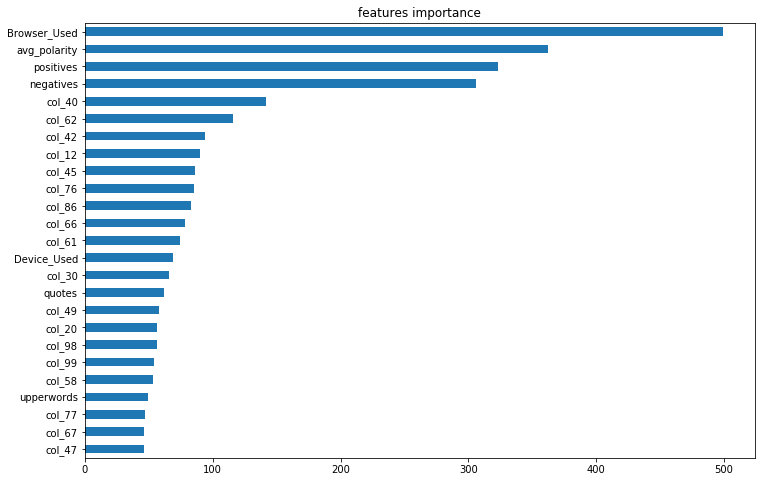

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the feature importance
model = XGBClassifier(max_depth=5, n_estimators=150, learning_rate=0.05)
model.fit(feats_final_train, target)

ts = pd.Series(model.booster().get_fscore())
ts.sort_values().iloc[-25:].plot(kind="barh", title=("features importance"), figsize=(12,8))

### Using word2vec

In [46]:
# Define methods to use word2vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if text is empty, return vector of zeros of same dimensions
        self.dim = len(word2vec.itervalues().next())
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                        or [np.zeros(self.dim)], axis=0) 
                for words in X])

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [47]:
# Let X be a list of tokenized texts (i.e. list of lists of tokens)
X = alldata['new_description'].str.split()
X = X.tolist()
X = np.array(X)

In [48]:
# Create a word2vec model to create features
model = gensim.models.Word2Vec(X, size=500)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [49]:
# Create features using tf-idf emmbedding
word2vec_ = TfidfEmbeddingVectorizer(w2v)
word2vec_.fit(X)
X_mod = word2vec_.transform(X)
X_mod

array([[ 1.05999875, -1.75540876,  0.51533693, ..., -1.06183577,
        -1.79106271,  0.74505621],
       [ 0.15768574, -0.28716439,  1.37845409, ...,  0.50808269,
         0.07610255,  0.13628483],
       [ 1.40665615, -2.35736871,  0.72671402, ..., -0.45514753,
        -1.18877149, -0.11313645],
       ..., 
       [-0.91711086, -1.99125063,  2.19191051, ..., -2.29708862,
         1.66557896, -1.15713632],
       [ 0.43100527,  1.76007104, -0.56951076, ..., -2.0424521 ,
         2.73676801, -2.19515562],
       [-2.53979635, -0.4567531 ,  2.17765594, ..., -2.31599808,
         1.31725168, -1.68216193]])

In [55]:
alldata.columns

Index([u'User_ID', u'Description', u'Browser_Used', u'Device_Used',
       u'Is_Response', u'questions', u'exclamations', u'upperwords', u'quotes',
       u'avg_polarity', u'new_description', u'positives', u'negatives'],
      dtype='object')

In [56]:
# create dataframe for features
X_mod_df = pd.DataFrame(X_mod)
# set column names
X_mod_df.columns = ['col' + str(x) for x in X_mod_df.columns]
# Final features using word2vec
alldata_ = pd.concat([alldata, X_mod_df], axis=1)
# Split train test features
feats_final_train = alldata_[:len(train)]
feats_final_test = alldata_[len(train):]

In [58]:
feature_cols = cols + X_mod_df.columns.tolist()

In [59]:
## Naive Bayes 1
model = GaussianNB()
print(cross_val_score(model, feats_final_train[feature_cols], target, cv=5, scoring=make_scorer(accuracy_score)))

[ 0.82575758  0.8209607   0.81941947  0.82686874  0.82006165]


In [68]:
from sklearn.svm import SVC

In [69]:
# Run cross validation using SVM
model = SVC(C=50, kernel='rbf', cache_size=800)
scores = cross_val_score(model, feats_final_train[feature_cols], target, cv=5, scoring=make_scorer(accuracy_score))
print scores

[ 0.85490498  0.85435397  0.85139995  0.85345492  0.84934498]


In [71]:
# Run logistic regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(tol=0.000001, n_jobs=-1)
scores = cross_val_score(model, feats_final_train[feature_cols], target, cv=5, scoring=make_scorer(accuracy_score))
print scores

[ 0.87930149  0.8764449   0.87631647  0.8764449   0.87683021]


In [52]:
# Run a cross validating using xgboost classifier
model = XGBClassifier(max_depth=50, n_estimators=300, learning_rate=0.05)
scores = cross_val_score(model, feats_final_train, target, cv=5, scoring=make_scorer(accuracy_score))
print scores

[ 0.88662044  0.88697662  0.89082969  0.88235294  0.88530696]


In [53]:
# Make predictions
model = XGBClassifier(max_depth=50, n_estimators=300, learning_rate=0.05)
model.fit(feats_final_train, target)
predictions = model.predict(feats_final_test)

In [54]:
# Make submission
submission = pd.DataFrame({'User_ID':test.User_ID, 'Is_Response':predictions})
submission['Is_Response'] = ['happy' if x == 1 else 'not_happy' for x in submission['Is_Response']]
submission = submission[['User_ID','Is_Response']]
submission.to_csv('submission2.csv', index=False)

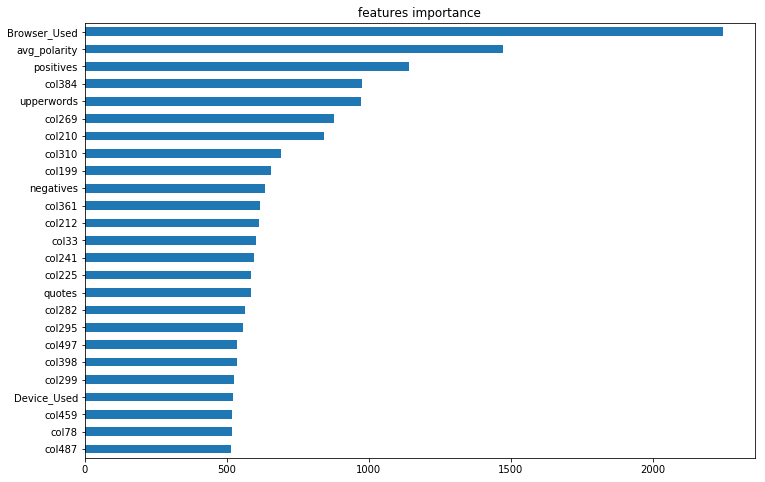

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the feature importance
model = XGBClassifier(max_depth=30, n_estimators=300, learning_rate=0.05)
model.fit(feats_final_train[feature_cols], target)

ts = pd.Series(model.booster().get_fscore())
ts.sort_values().iloc[-25:].plot(kind="barh", title=("features importance"), figsize=(12,8))

In [60]:
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(feats_final_train, target, test_size=0.30, random_state=42)

In [ ]:
# Prediction using xgboost
model = XGBClassifier(max_depth=50, n_estimators=300, learning_rate=0.05)
model.fit(X_train[feature_cols], y_train)

In [64]:
class_pred_xgb = model.predict(X_test[feature_cols])
prob_pred_xgb = model.predict_proba(X_test[feature_cols])

In [66]:
y_test = np.array(y_test)
print 'actual', 'predicted', 'probability_1', 'avg_polarity'
for i in xrange(50):
    print y_test[i], class_pred_xgb[i], prob_pred_xgb[i][1], X_test['avg_polarity'].iloc[i]

 actual predicted probability_1 avg_polarity
1 1 0.998964 0.33845
1 1 0.999219 0.353025
1 1 0.999642 0.480121428571
1 1 0.999683 0.404621428571
0 0 0.000406296 -0.1345
1 1 0.997047 0.438515789474
1 1 0.999729 0.523488888889
0 1 0.879978 0.6131
1 1 0.96422 0.332333333333
1 1 0.992344 0.145342857143
1 1 0.993064 0.363883333333
0 0 0.169773 0.277144444444
0 1 0.861428 0.017675
0 0 0.00198355 0.0940142857143
1 1 0.689855 0.2928
0 0 0.0651211 -0.005
1 1 0.722055 0.296225
0 0 0.000125655 -0.1190125
1 1 0.999756 0.612066666667
1 1 0.974119 0.365
1 1 0.840738 0.2728625
1 1 0.991022 0.61875
1 1 0.998541 0.612966666667
0 0 0.00137767 0.0981714285714
1 1 0.989116 0.452657142857
1 1 0.997671 0.457923076923
1 1 0.999655 0.707366666667
1 1 0.996925 0.4544
1 1 0.992755 0.46392
1 0 0.0754512 0.0456666666667
1 1 0.999356 0.8671
1 1 0.995746 0.738533333333
0 1 0.787197 0.6413
1 1 0.997825 0.401066666667
1 0 0.232314 0.241014285714
1 1 0.999848 0.389885714286
1 1 0.998475 0.475333333333
1 1 0.995395 0.34

In [72]:
# Prediction using logistic regression
model = LogisticRegression(tol=0.000001, n_jobs=-1)
model.fit(X_train[feature_cols], y_train)
class_pred_lr = model.predict(X_test[feature_cols])
prob_pred_lr = model.predict_proba(X_test[feature_cols])

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [73]:
y_test = np.array(y_test)
print 'actual', 'predicted', 'probability_1', 'avg_polarity'
for i in xrange(50):
    print y_test[i], class_pred_lr[i], prob_pred_lr[i][1], X_test['avg_polarity'].iloc[i]

actual predicted probability_1 avg_polarity
1 1 0.954428970112 0.33845
1 1 0.963427198757 0.353025
1 1 0.988438084373 0.480121428571
1 1 0.983653154402 0.404621428571
0 0 0.00470644508603 -0.1345
1 1 0.715189797244 0.438515789474
1 1 0.981140901086 0.523488888889
0 0 0.0555921655716 0.6131
1 1 0.847376050109 0.332333333333
1 1 0.985373030297 0.145342857143
1 1 0.679591068535 0.363883333333
0 0 0.357874182393 0.277144444444
0 0 0.460089677247 0.017675
0 0 0.0746333357292 0.0940142857143
1 1 0.788610003976 0.2928
0 0 0.256114492798 -0.005
1 0 0.243553508698 0.296225
0 0 0.000535377596822 -0.1190125
1 1 0.999202027445 0.612066666667
1 1 0.718882871495 0.365
1 0 0.245986565269 0.2728625
1 1 0.972931941802 0.61875
1 1 0.988675734608 0.612966666667
0 0 0.15203523774 0.0981714285714
1 1 0.976687728821 0.452657142857
1 1 0.915131493052 0.457923076923
1 1 0.998806451302 0.707366666667
1 1 0.980886367599 0.4544
1 1 0.840835922315 0.46392
1 0 0.328185510165 0.0456666666667
1 1 0.999100725334 0.86

In [74]:
# Make ensemble model using xgboost and logistic regression
model_xgb = XGBClassifier(max_depth=50, n_estimators=300, learning_rate=0.05)
model_lr = LogisticRegression(tol=0.000001)

# Using xgb
model_xgb.fit(X_train[feature_cols], y_train)
prob_pred_xgb = model.predict_proba(X_test[feature_cols])

# Using logistice regression
model_lr.fit(X_train[feature_cols], y_train)
prob_pred_lr = model.predict_proba(X_test[feature_cols])

In [81]:
probs = (prob_pred_xgb[:,1] + prob_pred_lr[:,1]) / 2
predictions_en = map(lambda x: 1 if x>=0.5 else 0, probs)

In [82]:
accuracy_score(y_test, predictions_en)

0.87748287671232872

In [83]:
# Cross validation using kfold
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
kf_predictions = []
for train_index, test_index in kf.split(feats_final_train[feature_cols]):
    train_data = feats_final_train[feature_cols].iloc[train_index]
    train_target = target.iloc[train_index]
    test_data = feats_final_train[feature_cols].iloc[test_index]
    test_target = target.iloc[test_index]
    # xgb
    model_xgb.fit(train_data, train_target)
    prob_pred_xgb = model.predict_proba(test_data)
    # lr
    model_lr.fit(train_data, train_target)
    prob_pred_lr = model.predict_proba(test_data)

    probs = (prob_pred_xgb[:,1] + prob_pred_lr[:,1]) / 2
    predictions_en = map(lambda x: 1 if x>=0.5 else 0, probs)
    
    score = accuracy_score(test_target, predictions_en)
    kf_predictions.append(score)

In [84]:
print kf_predictions

[0.88603791030975498, 0.88109732603837554, 0.88356322724820835]


In [91]:
# Model will be used to create bag of words data vectors
countvec = CountVectorizer(binary=True, max_features=10000)
countvecdata = countvec.fit_transform(alldata['new_description'])

In [93]:
print countvecdata.shape

(68336, 10000)


In [108]:
hash(''.join(map(str, countvecdata[0].toarray().tolist()[0])))

3804076405645389341

In [109]:
countvecdata = map(lambda x: hash(''.join(map(str, x.toarray().tolist()[0]))), countvecdata)

In [111]:
alldata['count_feats'] = countvecdata
alldata.columns

Index([u'User_ID', u'Description', u'Browser_Used', u'Device_Used',
       u'Is_Response', u'questions', u'exclamations', u'upperwords', u'quotes',
       u'avg_polarity', u'new_description', u'positives', u'negatives',
       u'count_feats'],
      dtype='object')

In [113]:
cols.append('count_feats')

In [115]:
model = LogisticRegression(tol=0.000001)
scores = cross_val_score(model, alldata[cols][:len(train)], target, cv=5, scoring=make_scorer(accuracy_score))
print scores

[ 0.49332306  0.50385307  0.48677113  0.50372463  0.49614693]


In [117]:
# Model will be used to create tf-idf data vectors using 3-gram
tfidfvec = TfidfVectorizer(ngram_range = (1,3), max_features=1000)

tfidfdata = tfidfvec.fit_transform(alldata['new_description'])

# create dataframe for features
tfidf_df = pd.DataFrame(tfidfdata.todense())
# set column names
tfidf_df.columns = ['col_' + str(x) for x in tfidf_df.columns]

In [118]:
# Final features using tf-idf vectors
feats = alldata[cols]
feats_final = pd.concat([feats, tfidf_df], axis=1)

In [119]:
# Split train test features
feats_final_train = feats_final[:len(train)]
feats_final_test = feats_final[len(train):]

In [120]:
model = LogisticRegression(tol=0.000001)
scores = cross_val_score(model, feats_final_train, target, cv=5, scoring=make_scorer(accuracy_score))
print scores

[ 0.8796867   0.87811456  0.88145389  0.87554585  0.87798613]


In [121]:
# Run a cross validating using xgboost classifier
model = XGBClassifier(max_depth=100, n_estimators=300, learning_rate=0.05)
scores = cross_val_score(model, feats_final_train, target, cv=3, scoring=make_scorer(accuracy_score))
print scores

[ 0.87494221  0.88387146  0.87593435]
